In [3]:
!pip install ndlinear

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from ndlinear import NdLinear
import matplotlib.pyplot as plt

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.6.0+cpu
No GPU found, using CPU instead.


In [2]:
batch_size = 10
data_dir = './data'
train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [3]:
for (Input, Label) in train_loader:
  print('data:', Input.size(), 'type', Input.type())
  print('label:', Label.size(), 'type', Label.type())
  break

data: torch.Size([10, 1, 28, 28]) type torch.FloatTensor
label: torch.Size([10]) type torch.LongTensor


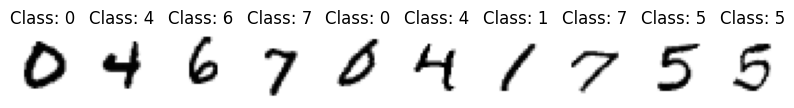

In [4]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(Input[i,:,:,:].numpy().reshape(28,28), cmap ='gray_r')
  plt.title('Class: '+str(Label[i].item()))

In [5]:
class NdLinearMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            NdLinear(input_dims=(784,), hidden_size=(20,)),
            nn.ReLU(),
            NdLinear(input_dims=(20,), hidden_size=(10,)),
        )

    def forward(self, x):
        return self.layers(x)


In [6]:
mlp = NdLinearMLP().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [7]:
def correct(output, label):
  predicted_labels = output.argmax(1)
  correct_ones = (predicted_labels == label).type(torch.float)
  return correct_ones.sum().item()

In [8]:
def train(data_loader, model, criterion, optimizer):
  model.train()

  num_batches = len(data_loader)
  num_items = len(data_loader.dataset)

  total_loss = 0
  total_correct = 0
  for input, label in data_loader:
    #Copy to GPU
    input = input.to(device)
    label = label.to(device)
    #forward pass
    output = model(input)

    #calculate the loss
    loss = criterion(output, label)
    total_loss += loss

    #count number of correct
    total_correct += correct(output, label)

    #backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  train_loss = total_loss/num_batches
  accuracy = total_correct/num_items
  print(f'Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}')

In [9]:
%%time

epochs = 10
for epoch in range(epochs):
  print(f'Training epoch: {epoch+1}')
  train(train_loader, mlp, loss_fn, optimizer)

Training epoch: 1
Average loss: 0.365543, accuracy: 89.87%
Training epoch: 2
Average loss: 0.213758, accuracy: 93.88%
Training epoch: 3
Average loss: 0.177022, accuracy: 94.93%
Training epoch: 4
Average loss: 0.157042, accuracy: 95.41%
Training epoch: 5
Average loss: 0.145789, accuracy: 95.76%
Training epoch: 6
Average loss: 0.135981, accuracy: 96.02%
Training epoch: 7
Average loss: 0.129457, accuracy: 96.14%
Training epoch: 8
Average loss: 0.124626, accuracy: 96.33%
Training epoch: 9
Average loss: 0.120878, accuracy: 96.39%
Training epoch: 10
Average loss: 0.116975, accuracy: 96.50%
CPU times: total: 7min 9s
Wall time: 3min 38s


In [10]:
def evaluate(test_loader, model, criterion):
  mlp.eval()

  num_batches = len(test_loader)
  num_items = len(test_loader.dataset)

  test_loss = 0
  total_correct = 0

  with torch.no_grad():
    for input, label in test_loader:
      #Copy to GPU
      input = input.to(device)
      label = label.to(device)

      #forward pass
      output = model(input)

      #calculate loss
      loss = criterion(output, label)
      test_loss += loss.item()

      #Count correct digits
      total_correct += correct(output, label)

  test_loss = test_loss/num_batches
  accuracy = total_correct/num_items

  print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

def test_predict(data_loader, model):
  for (input, label) in train_loader:
    break

  pltsize = 1
  plt.figure(figsize=(10*pltsize, pltsize))

  for i in range(1):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    output = model(input[i,:,:,:])
    plt.imshow(input[i,:,:,:].numpy().reshape(28,28), cmap ='gray_r')
    predict = output.argmax(1).tolist()
    predict = predict[0]
    plt.title(f'Actual: {str(label[i].item())}, Prediction: {str(predict)}')

In [11]:
evaluate(test_loader, mlp, loss_fn)

Testset accuracy: 95.1%, average loss: 0.161002


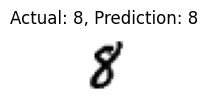

In [57]:
test_predict(test_loader, mlp)